In [32]:
!pip install scikit-surprise

In [33]:
import pandas as pd
from googleapiclient.discovery import build
from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
import os
import pickle
import io
from googleapiclient.http import MediaIoBaseDownload
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.similarities import pearson
from surprise import Dataset, Reader
from surprise import accuracy
from sklearn.metrics import mean_squared_error

In [11]:
# Scopes for the Google Drive API
SCOPES = ['https://www.googleapis.com/auth/drive']

def authenticate_google_drive():
    creds = None
    if os.path.exists('token.pickle'):
        with open('token.pickle', 'rb') as token:
            creds = pickle.load(token)
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            creds.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(
                'new_client_id.json', SCOPES)
            creds = flow.run_local_server(port=0)
        # Save the credentials for the next run
        with open('token.pickle', 'wb') as token:
            pickle.dump(creds, token)

    service = build('drive', 'v3', credentials=creds)
    return service

drive_service = authenticate_google_drive()

def download_file(file_id, file_name):
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.FileIO(file_name, 'wb')
    downloader = MediaIoBaseDownload(fh, request)
    done = False
    while done is False:
        status, done = downloader.next_chunk()
        print(f"Download {int(status.progress() * 100)}%.")

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=931696450107-uflia2gbnmg8q3gquonhp4llip5jkp3p.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A63805%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&state=8H8fciYWwprFx56E8rKCbjaotJ1crp&access_type=offline


In [14]:
file_id = '1039e61fo7FSjobH-u9B-xOT62Abw4GLF'
file_name = 'ba_reviews.csv'
download_file(file_id, file_name)

df = pd.read_csv(file_name)

Download 52%.
Download 100%.


In [15]:
# Drop all columns not needed for surprise collaberative filtering modeling from the beer reviews df
df = df[['review_profilename','beer_beerid','review_time','review_overall']]
df.head()

,review_profilename,beer_beerid,review_time,review_overall
0,stcules,47986,1234817823,1.5
1,stcules,48213,1235915097,3.0
2,stcules,48215,1235916604,3.0
3,stcules,47969,1234725145,3.0
4,johnmichaelsen,64883,1293735206,4.0


In [16]:
df.dropna(axis=0, how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586266 entries, 0 to 1586613
Data columns (total 4 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   review_profilename  1586266 non-null  object 
 1   beer_beerid         1586266 non-null  int64  
 2   review_time         1586266 non-null  int64  
 3   review_overall      1586266 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 60.5+ MB


In [17]:
# Convert review ratings in beer reviews df from a scale of (0,5,.5) to a scale of (0,10,1)
df['review_overall'] = df['review_overall']*2
df['review_overall'] = df['review_overall'].astype(int)
df.head()

,review_profilename,beer_beerid,review_time,review_overall
0,stcules,47986,1234817823,3
1,stcules,48213,1235915097,6
2,stcules,48215,1235916604,6
3,stcules,47969,1234725145,6
4,johnmichaelsen,64883,1293735206,8


In [18]:
df.to_csv('formatted_beer_reviews.csv', index=False)

# Explore Data

Calculate the mean of all beer review scores

In [19]:
df['review_overall'].mean()

7.631256044068271

In [20]:
df['review_overall'].std()

1.4411896227439236

In [21]:
df['review_overall'].median()

8.0

/var/folders/5j/c9vk68bx423f99hmd4hy32k80000gn/T/ipykernel_60838/2098384204.py:2: UserWarning: FixedFormatter should only be used together with FixedLocator
  countplot.set_yticklabels(['0','10,000','20,000','30,000','40,000','50,000','60,000'])


Text(0.5, 1.0, 'Frequency Count by Review Score')

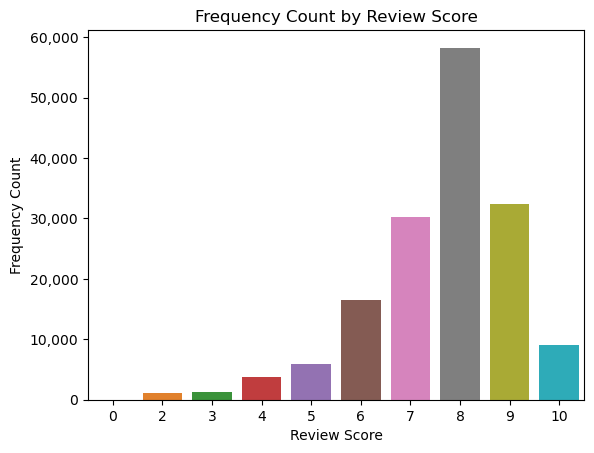

In [24]:
countplot = sns.countplot(x='review_overall',data=df)
countplot.set_yticklabels(['0','10,000','20,000','30,000','40,000','50,000','60,000'])
countplot.set_xlabel('Review Score')
countplot.set_ylabel('Frequency Count')
countplot.set_title('Frequency Count by Review Score')

Create a chart of the value counts of all beer review scores

In [25]:
df.groupby('review_overall').count().iloc[:,0]

review_overall
0          7
2      10954
3      12973
4      38207
5      58486
6     165583
7     301750
8     582684
9     324323
10     91299
Name: review_profilename, dtype: int64

Create a plot of the distribution of mean beer review scores across users

/var/folders/5j/c9vk68bx423f99hmd4hy32k80000gn/T/ipykernel_60838/3378688831.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_mean, kde=False, bins=9)


<Axes: xlabel='review_overall'>

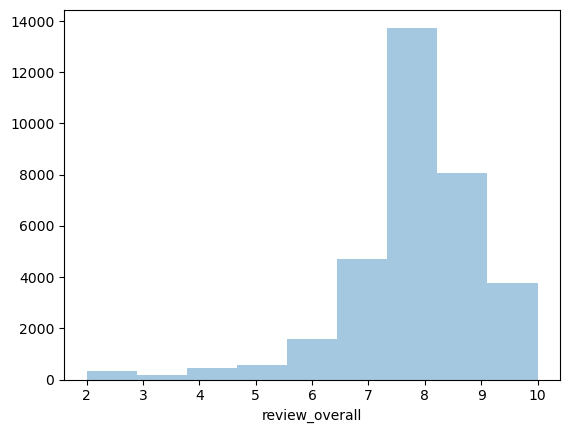

In [26]:
user_mean = df.groupby('review_profilename').mean()['review_overall']
sns.distplot(user_mean, kde=False, bins=9)

Create a plot of the distribution of mean beer review scores across beers

/var/folders/5j/c9vk68bx423f99hmd4hy32k80000gn/T/ipykernel_60838/313359156.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  bear_mean = df.groupby('beer_beerid').mean()['review_overall']
/var/folders/5j/c9vk68bx423f99hmd4hy32k80000gn/T/ipykernel_60838/313359156.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(bear_mean, kde=False, bins=9)


<Axes: xlabel='review_overall'>

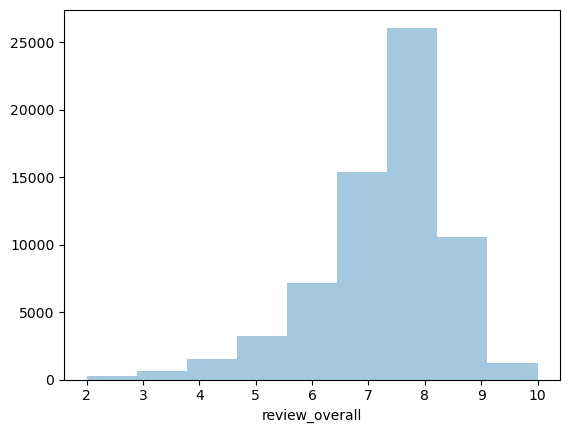

In [27]:
bear_mean = df.groupby('beer_beerid').mean()['review_overall']
sns.distplot(bear_mean, kde=False, bins=9)

Calculate the descriptive statistics for number of reviews by user

In [28]:
user_review_count = df.groupby('review_profilename').count().iloc[:,0]
user_review_count.describe()

count    33387.000000
mean        47.511487
std        182.599759
min          1.000000
25%          1.000000
50%          3.000000
75%         16.000000
max       5817.000000
Name: beer_beerid, dtype: float64

Calculate the descriptive statistics for number of reviews by beer

In [29]:
beer_review_count = df.groupby('beer_beerid').count().iloc[:,0]
beer_review_count.describe()

count    66051.000000
mean        24.015776
std        110.838706
min          1.000000
25%          1.000000
50%          2.000000
75%          7.000000
max       3289.000000
Name: review_profilename, dtype: float64

# Model Data

Read formatted_beer_reviews csv file into Surprise

In [34]:
reader = Reader(rating_scale=(0,10), line_format='user item timestamp rating', 
                sep = ',',skip_lines=1)
dataset = Dataset.load_from_file('formatted_beer_reviews.csv', reader)
trainset, testset = train_test_split(dataset, test_size=0.2, random_state = 71)

Calculate evaluation metrics for baseline model

In [35]:
baseline_pred = np.array([df['review_overall'].mean()]*len(df['review_overall']))
actuals = np.array(df['review_overall'])
baseline_rmse = sum(np.square((baseline_pred-actuals)))/len(df['review_overall'])
baseline_mae = sum(np.abs((baseline_pred-actuals)))/len(df['review_overall'])
print('MAE: ', baseline_mae)
print('RMSE: ', baseline_rmse)

MAE:  1.103270578412246
RMSE:  2.0770262193231632


Calculate evaluation metrics for knn model (k=1)

In [36]:
knn = KNNBasic(k=1, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  1.2679
RMSE: 1.7401


1.7401124714867655

Calculate evaluation metrics for knn model (k=10)

In [37]:
knn = KNNBasic(k=20, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9461
RMSE: 1.2712


1.2712010880925555

Calculate evaluation metrics for knn model (k=30)

In [38]:
knn = KNNBasic(k=30, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9387
RMSE: 1.2626


1.2625541391381911

Calculate evaluation metrics for knn model (k=40)

In [39]:
knn = KNNBasic(k=40, verbose = True)
knn.fit(trainset)
knn_predictions = knn.test(testset)
accuracy.mae(knn_predictions)
accuracy.rmse(knn_predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
MAE:  0.9352
RMSE: 1.2585


1.2584695805088943

Calculate evaluation metrics for svd model (factors=10)

In [40]:
svd = SVD(n_factors=10, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9073
RMSE: 1.2130


1.2130108025454982

Calculate evaluation metrics for svd model (factors=20)

In [41]:
svd = SVD(n_factors=20, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9066
RMSE: 1.2123


1.212304354148149

Calculate evaluation metrics for svd model (factors=15)

In [42]:
svd = SVD(n_factors=15, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9063
RMSE: 1.2122


1.212243458448613


Calculate evaluation metrics for svd model (factors=25)

In [43]:
svd = SVD(n_factors=25, n_epochs=10, verbose = True)
svd.fit(trainset)
svd_predictions = svd.test(testset)
accuracy.mae(svd_predictions)
accuracy.rmse(svd_predictions)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
MAE:  0.9069
RMSE: 1.2127


1.2127262458750865